# Setting up the notebook


In [1]:
#installing AIF360
!pip install 'aif360'
!pip install 'fairlearn'

In [2]:
#Import all the necessary libaries and setting the random seed 

import numpy as np
from aif360.datasets import AdultDataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german
from aif360.algorithms.preprocessing.reweighing import Reweighing
import pdb
from sklearn.svm import SVC as svc 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std


np.random.seed(0)

# Functions used to do the tasks

## Functions used in each task

In [3]:
#define a function to run the model with selected hyperparameter and give the accuracy and other metrics
def runmodel(train, test, c):
    scale_orig = StandardScaler()
    X_train = scale_orig.fit_transform(train.features)
    y_train = train.labels.ravel()

    X_test = scale_orig.transform(test.features) 
    y_test = test.labels.ravel()

    learner = LogisticRegression(solver='liblinear', random_state=1,C=c)  
    learner.fit(X_train,y_train)
    predictions = learner.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = predictions

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
      #would like it to be close to 0.
    metric_arrs['acc']=(metric.accuracy())
    
    #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
    #towards priviliged.
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    metric_arrs['disp_imp']=(metric.disparate_impact())
    print(metric_arrs)
    return

    

In [4]:
#define a function to run the model with selected hyperparameter and give the accuracy and other metrics with Reweighing
def runmodelrw(train, test, c):
    learner = LogisticRegression(solver='liblinear', random_state=1,C=c)     
    scale_orig = StandardScaler()
    X_train = scale_orig.fit_transform(train.features)
    y_train = train.labels.ravel()

    X_test = scale_orig.transform(test.features) 
    y_test = test.labels.ravel()
    RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
#We obtain a set of weights for the training set, to use in scikit-learn.
    trainw = RW.fit_transform(train)
    learner.fit(X_train,y_train,sample_weight=trainw.instance_weights) 
 
    predictions = learner.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = predictions

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
      #would like it to be close to 0.
    metric_arrs['acc']=(metric.accuracy())
    
    #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
    #towards priviliged.
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning 
    #that the classifier can equally detect positive and negative classes. 
    metric_arrs['disp_imp']=(metric.disparate_impact())
    print(metric_arrs)
    return

    

## Functions used to do task 1

In [5]:
#function to carry out crossvalidation on LogisticRegression varying the C

def logreg(train, test):
  c_values =  [100,10, 1.0, 0.1, 0.01,0.001,0.0001, 0.00001]
  splits = 5
  val=0
  m = 0
  l =[]
  mean = []
  folds = KFold(n_splits=splits, random_state=1, shuffle=True)
  
  for item in c_values:                # loop for each differnt value of the hyper parameter
    if val != 0:
      m = m/5
      mean.append(m)
      m = 0
      val= val/5
      l.append(val)
      val= 0
    
    print()
    learner = LogisticRegression(solver='liblinear', C = item)  

    print("for value of c:", item)
    i = 1
    for trainf , testf in folds.split(train.features):
      print("Fold: ", i)
      train1,test1 = train.subset(trainf),train.subset(testf)
      
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train1.features)
      y_train = train1.labels.ravel()
      X_test = scale_orig.transform(test1.features) 
      y_test = test1.labels.ravel()

      learner.fit(X_train,y_train)
      predictions = learner.predict(X_test)
      test_pred = test1.copy()
      test_pred.labels = predictions
      
      metric = ClassificationMetric(test1, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      #would like it to be close to 0.
      metric_arrs['acc']=(metric.accuracy())
    #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
    #towards priviliged.
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
      metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning 
    #that the classifier can equally detect positive and negative classes.
      metric_arrs['disp_imp']=(metric.disparate_impact())
      print(metric_arrs)
      i = i+1
      val+=metric.accuracy()
      m += metric.equal_opportunity_difference()
  m = m/5
  mean.append(m)
  val=val/5
  l.append(val)
  return(l,mean)

 



In [6]:
#function to output the cross validation results as a graph for easier selection
def tuningcv(train,test):
  
  L , M = logreg(train,test)
  plt.rcParams["figure.figsize"] = [7.00, 3.50]
  plt.rcParams["figure.autolayout"] = True
  x = [100,10, 1.0, 0.1, 0.01,0.001,0.0001, 0.00001]
  y1 = L
  y2 = M
  default_x_ticks = range(len(x))
  plt.plot(default_x_ticks, y1)
  plt.xticks(default_x_ticks, x)
  plt.xlabel("Value of C")
  plt.ylabel("Accuracy")
  plt.show()
  default_x_ticks = range(len(x))
  plt.plot(default_x_ticks, y2)
  plt.xticks(default_x_ticks, x)
  plt.xlabel("Value of C")
  plt.ylabel("Equal Opportunity Difference")
  plt.show()
  return

## Functions used in Task 2

In [7]:
#function to carry out crossvalidation on LogisticRegression varying the C while doing Reweighing to get fairier weights for a fairer result
def logregrw(train, test):
  c_values =  [100,10, 1.0, 0.1, 0.01,0.001,0.0001, 0.00001]
  splits = 5
  val=0
  m = 0
  l =[]
  mean = []
  folds = KFold(n_splits=splits, random_state=1, shuffle=True)
  for item in c_values:
    if val != 0:
      m = m/5
      mean.append(m)
      m = 0
      val= val/5
      l.append(val)
      val= 0
    
    print()
    learner = LogisticRegression(solver='liblinear', C = item)  

    print("for value of c:", item)
    i = 1
    for trainf , testf in folds.split(train.features):
      print("Fold: ", i)
      train1,test1 = train.subset(trainf),train.subset(testf)
      
      scale_orig = StandardScaler()
      X_train = scale_orig.fit_transform(train1.features)
      y_train = train1.labels.ravel()
      X_test = scale_orig.transform(test1.features) 
      y_test = test1.labels.ravel()
      RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
#We obtain a set of weights for the training set, to use in scikit-learn.
      trainw = RW.fit_transform(train1)
      learner.fit(X_train,y_train,sample_weight=trainw.instance_weights) 
      predictions = learner.predict(X_test)
      test_pred = test1.copy()
      test_pred.labels = predictions
      
      metric = ClassificationMetric(test1, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
      metric_arrs = {}
      #would like it to be close to 0.
      metric_arrs['acc']=(metric.accuracy())
    #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
    #towards priviliged.
      metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
      metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning 
    #that the classifier can equally detect positive and negative classes.
      metric_arrs['disp_imp']=(metric.disparate_impact())
      print(metric_arrs)
      i = i+1
      val+=metric.accuracy()
      m += metric.equal_opportunity_difference()
  m = m/5
  mean.append(m)
  val=val/5
  l.append(val)
  return(l,mean)

 






In [8]:
#function to do output the cross validation results as a graph for easier selection
def tuningcvrw(train,test):
  
  L , M = logregrw(train,test)
  plt.rcParams["figure.figsize"] = [10.00, 5.50]
  plt.rcParams["figure.autolayout"] = True
  x = [100,10, 1.0, 0.1, 0.01,0.001,0.0001, 0.00001]
  y1 = L
  y2 = M
  default_x_ticks = range(len(x))
  plt.plot(default_x_ticks, y1)
  plt.xticks(default_x_ticks, x)
  plt.xlabel("Value of C")
  plt.ylabel("Accuracy")
  plt.show()
  default_x_ticks = range(len(x))
  plt.plot(default_x_ticks, y2)
  plt.xticks(default_x_ticks, x)
  plt.xlabel("Value of C")
  plt.ylabel("Equal Opportunity Difference")
  plt.show()
  return

## (Extra) Functions used to do Task 1 and 2 using RandomForestClassifier and RandomisedSearchCV

In [9]:
#function to plot grid search cv results
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')


In [10]:
#function to carry out GridSearchCV on RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
def rf(train, test):
  
    learner = RandomForestClassifier(n_estimators = 200)  
    scale_orig = RobustScaler()
    X_train = scale_orig.fit_transform(train.features)
    y_train = train.labels.ravel()
    X_test = scale_orig.transform(test.features) 
    y_test = test.labels.ravel()

    
    
    from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
    n_estimators =  [50,100, 200]
    max_depth = [80,90,100,110]
    param_grid = {
        'max_depth': [80, 90, 100,110],
        'n_estimators': [50,100, 200]
        }
# Create a based model
    learner = RandomForestClassifier()
# Instantiate the grid search model
    grid_search = GridSearchCV(estimator = learner, param_grid = param_grid,  cv = 5, n_jobs = -1, verbose = 2)  
    grid_search.fit(X_train, y_train)
    plot_grid_search(grid_search.cv_results_, n_estimators, max_depth, 'N Estimators', 'Max Depth')
    return()
 



In [11]:
#function to carry out GridSearchCV on RandomForestClassifier with reweighing
from sklearn.ensemble import RandomForestClassifier
def rfrw(train, test):

    
    print()
    learner = RandomForestClassifier()  

    scale_orig = RobustScaler()
    X_train = scale_orig.fit_transform(train.features)
    y_train = train.labels.ravel()
    X_test = scale_orig.transform(test.features) 
    y_test = test.labels.ravel()
    RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
#We obtain a set of weights for the training set, to use in scikit-learn.
    trainw = RW.fit_transform(train)
    from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
    n_estimators =  [50,100, 200]
    max_depth = [80,90,100,110]
    param_grid = {
        'max_depth': [80, 90, 100,110],
        'n_estimators': [50,100, 200]
        }
# Create a based model
    learner = RandomForestClassifier()
# Instantiate the grid search model
    grid_search = GridSearchCV(estimator = learner, param_grid = param_grid,  cv = 5, n_jobs = -1, verbose = 2)  
    grid_search.fit(X_train, y_train,sample_weight=trainw.instance_weights)
    plot_grid_search(grid_search.cv_results_, n_estimators, max_depth, 'N Estimators', 'Max Depth')
    return()
  
 






In [12]:
#define a function to run the model with selected hyperparameter and give the accuracy and other metrics
def runmodelrf(train, test, n,m):
    scale_orig = StandardScaler()
    X_train = scale_orig.fit_transform(train.features)
    y_train = train.labels.ravel()

    X_test = scale_orig.transform(test.features) 
    y_test = test.labels.ravel()

    learner = RandomForestClassifier(n_estimators= n , max_depth = m)  
    learner.fit(X_train,y_train)
    predictions = learner.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = predictions

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
      #would like it to be close to 0.
    metric_arrs['acc']=(metric.accuracy())
    #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
    #towards priviliged.
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning 
    #that the classifier can equally detect positive and negative classes.
    metric_arrs['disp_imp']=(metric.disparate_impact())
    print(metric_arrs)
    return

    

In [13]:
def runmodelrfrw(train, test, n,m):
    learner = RandomForestClassifier(n_estimators=n , max_depth= m)     
    scale_orig = StandardScaler()
    X_train = scale_orig.fit_transform(train.features)
    y_train = train.labels.ravel()

    X_test = scale_orig.transform(test.features) 
    y_test = test.labels.ravel()
    RW = Reweighing(unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
#We obtain a set of weights for the training set, to use in scikit-learn.
    trainw = RW.fit_transform(train)
    learner.fit(X_train,y_train,sample_weight=trainw.instance_weights) 
 
    predictions = learner.predict(X_test)

    test_pred = test.copy()
    test_pred.labels = predictions

    metric = ClassificationMetric(test, test_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    metric_arrs = {}
      #would like it to be close to 0.
    metric_arrs['acc']=(metric.accuracy())

    #Equal opportunity difference measures the ability of the classifier to accurately classify a datapoint as positive
    #regardless of the presence of the unpriviliged feature. We would like it to be close to 0. A negative value signals bias
    #towards priviliged.
    metric_arrs['eq_opp_diff']=(metric.equal_opportunity_difference())
    #Average of difference in FPR and TPR for unprivileged and privileged groups. A value of 0 indicates equality of odds.
    metric_arrs['avg_odds_diff']=(metric.average_odds_difference())
    #Balanced accuracy is a general metric, not dependent on bias. We would like to have it close to 1, meaning 
    #that the classifier can equally detect positive and negative classes.
    metric_arrs['disp_imp']=(metric.disparate_impact())
    print(metric_arrs)
    return

# Dataset 1 - Adult Dataset

##Setting up the Dataset

In [14]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [15]:
#Downloading the data files( in this case the adult income dataset)
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test 


--2022-05-13 14:46:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.9’

adult.data.9        100%[===================>]   3.79M  6.81MB/s    in 0.6s    

2022-05-13 14:46:03 (6.81 MB/s) - ‘adult.data.9’ saved [3974305/3974305]

--2022-05-13 14:46:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names.9’

adult.names.9       100%[===================>]   5.11K  --.-KB/s    in 0s      


In [16]:
#loading the dataset and slecting the priveleged and un-priveleged groups
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.sklearn.datasets import fetch_adult
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])


#splitting the data into train and test
train, test = dataset_orig.split([0.7], shuffle=True)
print("training data size", train.features.shape)
print("dataset feature names", train.feature_names)

#printing the entire dataset 
print(dataset_orig)

training data size (34189, 18)
dataset feature names ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']
               instance weights features                                      \
                                         protected attribute                   
                                    race                 sex Age (decade)=10   
instance names                                                                 
0                           1.0      0.0                 1.0             0.0   
1                           1.0      1.0                 1.0             0.0   
2                           1.0      1.0                 1.0             0.0   
3                           1.0      0.0 

## Task 1


for value of c: 100
Fold:  1
{'acc': 0.8015501608657503, 'eq_opp_diff': -0.46934306569343065, 'avg_odds_diff': -0.2928220030661511, 'disp_imp': 0.0}
Fold:  2
{'acc': 0.8060836501901141, 'eq_opp_diff': -0.4722222222222222, 'avg_odds_diff': -0.2881684677195899, 'disp_imp': 0.0}
Fold:  3
{'acc': 0.8021351272301843, 'eq_opp_diff': -0.4718861209964413, 'avg_odds_diff': -0.2899671416135565, 'disp_imp': 0.0}
Fold:  4
{'acc': 0.8060836501901141, 'eq_opp_diff': -0.46070656092285506, 'avg_odds_diff': -0.28342771411838547, 'disp_imp': 0.0}
Fold:  5
{'acc': 0.8038613426941641, 'eq_opp_diff': -0.4544138929088278, 'avg_odds_diff': -0.28053191508678527, 'disp_imp': 0.0}

for value of c: 10
Fold:  1
{'acc': 0.8015501608657503, 'eq_opp_diff': -0.46934306569343065, 'avg_odds_diff': -0.2928220030661511, 'disp_imp': 0.0}
Fold:  2
{'acc': 0.8060836501901141, 'eq_opp_diff': -0.4722222222222222, 'avg_odds_diff': -0.2881684677195899, 'disp_imp': 0.0}
Fold:  3
{'acc': 0.8021351272301843, 'eq_opp_diff': -0.471

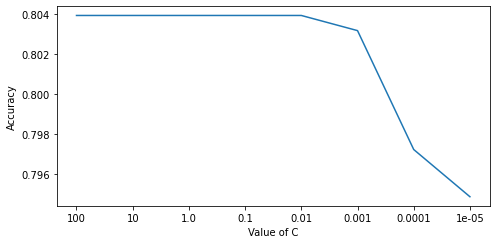

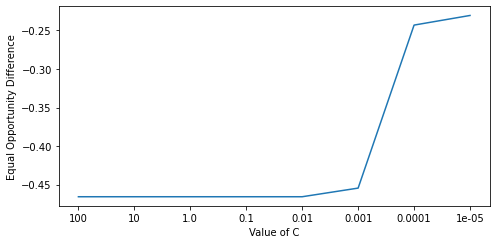

In [17]:
#running crossvalidation for hyperparameter tuning
tuningcv(train,test)

We can see from the about graphs that:


 

*   The best Value of C for the most accurate result can be any of the values above 0.01 ( we will use 0.01)
*   The best Value of C for the most fair result will 0.00001



In [18]:
#calculating the metrics of the most accurate and most fiar result
#Geting the metrics of the most accurate result
print("The metrics of the most accurate result:")
runmodel(train,test,0.01) #most accurate result at C = 0.01
#Geting the metrics of the most fair result
print("The metrics of the most fair result:")
runmodel(train,test,0.00001) #most accurate result at C = 0.00001

The metrics of the most accurate result:
{'acc': 0.8042039172865625, 'eq_opp_diff': -0.4414141414141414, 'avg_odds_diff': -0.27273605621431707, 'disp_imp': 0.0}
The metrics of the most fair result:
{'acc': 0.7975841124684365, 'eq_opp_diff': -0.2189742958035641, 'avg_odds_diff': -0.14215121728866864, 'disp_imp': 0.3285450819595489}


We can see that there is a slight difference in the accuracy while the fairness metrics improve noticeably.

##Task 2




for value of c: 100
Fold:  1
{'acc': 0.7886809008482012, 'eq_opp_diff': -0.04401826226643746, 'avg_odds_diff': -0.023006319287756892, 'disp_imp': 0.6574805029736868}
Fold:  2
{'acc': 0.7955542556303012, 'eq_opp_diff': -0.018595135128999685, 'avg_odds_diff': -0.0125320446628931, 'disp_imp': 0.6312249486753349}
Fold:  3
{'acc': 0.7859023106171396, 'eq_opp_diff': 0.0035982601818900783, 'avg_odds_diff': 0.006839000051785525, 'disp_imp': 0.7283906256238272}
Fold:  4
{'acc': 0.791459491079263, 'eq_opp_diff': -0.011077144917087223, 'avg_odds_diff': -0.012304411437294153, 'disp_imp': 0.604090681640005}
Fold:  5
{'acc': 0.7868948369167764, 'eq_opp_diff': 0.016100587659731547, 'avg_odds_diff': 0.013422854297957754, 'disp_imp': 0.7338321263373853}

for value of c: 10
Fold:  1
{'acc': 0.7886809008482012, 'eq_opp_diff': -0.04401826226643746, 'avg_odds_diff': -0.023006319287756892, 'disp_imp': 0.6574805029736868}
Fold:  2
{'acc': 0.7955542556303012, 'eq_opp_diff': -0.018595135128999685, 'avg_odds_d

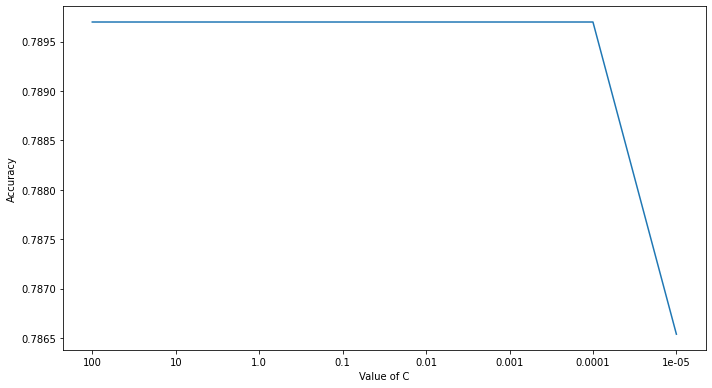

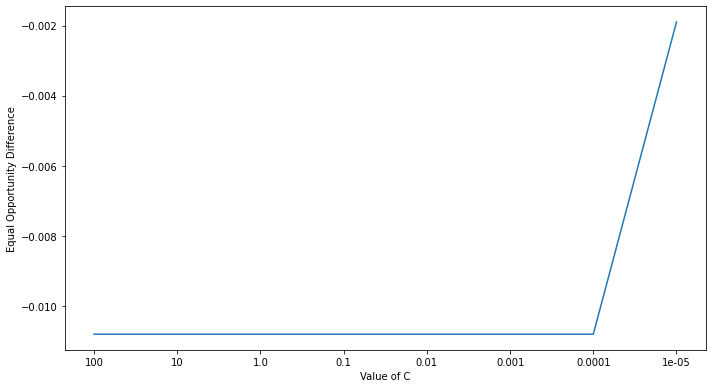

In [19]:
#running crossvalidation for hyperparameter tuning with reweighing
tuningcvrw(train, test)

We can see from the about graphs that:


 

*   The best Value of C for the most accurate result can be any of the values above 0.0001 ( we will use 0.01)
*   The best Value of C for the most fair result will be 0.00001



In [20]:
#calculating the metrics of the most accurate and most fiar result
#Geting the metrics of the most accurate result
print("The metrics of the most accurate result:")
runmodelrw(train,test,0.01) #most accurate result at C = 0.01
#Geting the metrics of the most fair result
print("The metrics of the most fair result:")
runmodelrw(train,test,0.00001) #most accurate result at C = 0.00001

The metrics of the most accurate result:
{'acc': 0.7905548351873336, 'eq_opp_diff': 0.03513180586351322, 'avg_odds_diff': 0.019935709638750347, 'disp_imp': 0.706625314122085}
The metrics of the most fair result:
{'acc': 0.7876202825359995, 'eq_opp_diff': 0.03327174180832715, 'avg_odds_diff': 0.018499072954967583, 'disp_imp': 0.7112690779845287}


We can see that after reweighing there is a massive improvement in the fairness of the model with a little compromise in accuracy.

## Extra (Best model according to GridSearchCV for TASK 1 and 2 with Random Forest)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


()

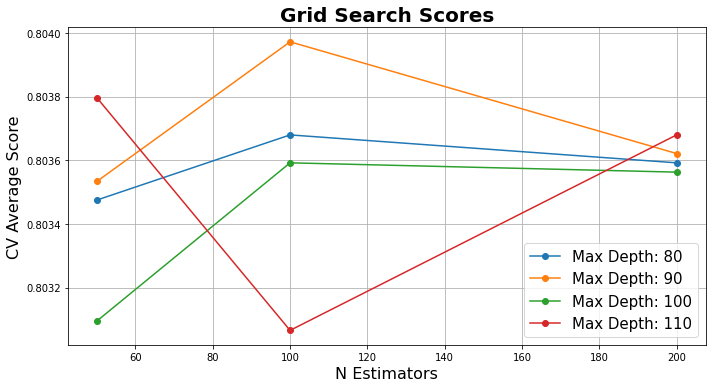

In [21]:
#running the GridSearchCV for RandomForest
rf(train,test)

In [22]:
#running the best RandomForestClassifier Model according to the GridSearchCV result
runmodelrf(train,test,100,90)

{'acc': 0.8039309356445778, 'eq_opp_diff': -0.44545454545454544, 'avg_odds_diff': -0.27591567852437415, 'disp_imp': 0.0}



Fitting 5 folds for each of 12 candidates, totalling 60 fits


()

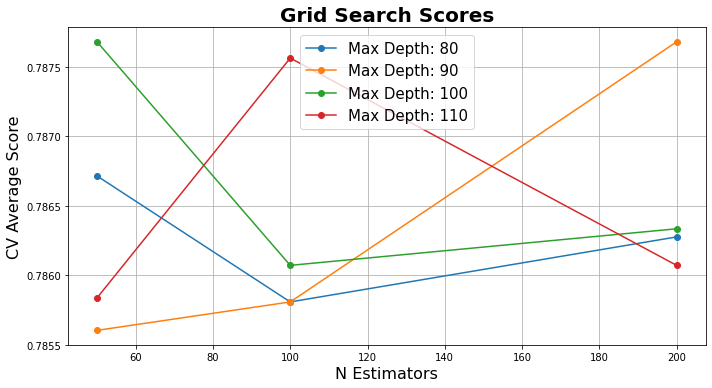

In [23]:
#running the GridSearchCV for RandomForest with reweighing
rfrw(train,test)

In [24]:
#running the best RandomForestClassifier Model according to the GridSearchCV result with reweighing
runmodelrfrw(train,test,100,100)

{'acc': 0.7901453627243568, 'eq_opp_diff': 0.0036831731953683167, 'avg_odds_diff': -0.0019184909491867796, 'disp_imp': 0.6451820420648191}


We can observe a serious improvement in fairness after reweighing and using RandonForest. The Fairness and Accuracy is overall better then Logistic Regression Models espically after Reweighing.

# Dataset 2 - Greman Dataset

##Setting up the dataset

In [25]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [26]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc


--2022-05-13 14:49:03--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data.8’

german.data.8       100%[===================>]  77.92K  --.-KB/s    in 0.1s    

2022-05-13 14:49:04 (561 KB/s) - ‘german.data.8’ saved [79793/79793]

--2022-05-13 14:49:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.doc
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4679 (4.6K) [application/x-httpd-php]
Saving to: ‘german.doc.8’

german.doc.8        100%[===================>]   4.57K  --.-KB/s    i

In [27]:

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_german(['sex'])


#STEP 3: We split between training and test set.
german_train, german_test = dataset_orig.split([0.7], shuffle=True,seed=np.random.seed(0))
print("training data size", german_train.features.shape)
print("dataset feature names", german_train.feature_names)


training data size (700, 11)
dataset feature names ['age', 'sex', 'credit_history=Delay', 'credit_history=None/Paid', 'credit_history=Other', 'savings=500+', 'savings=<500', 'savings=Unknown/None', 'employment=1-4 years', 'employment=4+ years', 'employment=Unemployed']


In [28]:
dataset_orig

               instance weights features                      \
                                         protected attribute   
                                     age                 sex   
instance names                                                 
0                           1.0      1.0                 1.0   
1                           1.0      0.0                 0.0   
2                           1.0      1.0                 1.0   
3                           1.0      1.0                 1.0   
4                           1.0      1.0                 1.0   
...                         ...      ...                 ...   
995                         1.0      1.0                 0.0   
996                         1.0      1.0                 1.0   
997                         1.0      1.0                 1.0   
998                         1.0      0.0                 1.0   
999                         1.0      1.0                 1.0   

                                       

##Task 1


for value of c: 100
Fold:  1
{'acc': 0.75, 'eq_opp_diff': 0.009981851179673318, 'avg_odds_diff': -0.14500907441016336, 'disp_imp': 0.8925619834710745}
Fold:  2
{'acc': 0.6142857142857143, 'eq_opp_diff': -0.10140845070422533, 'avg_odds_diff': -0.18113900796080834, 'disp_imp': 0.8271317829457364}
Fold:  3
{'acc': 0.7142857142857143, 'eq_opp_diff': -0.19999999999999996, 'avg_odds_diff': -0.22499999999999998, 'disp_imp': 0.7906976744186046}
Fold:  4
{'acc': 0.7, 'eq_opp_diff': -0.029713114754098324, 'avg_odds_diff': -0.21050873129009262, 'disp_imp': 0.819277108433735}
Fold:  5
{'acc': 0.6714285714285714, 'eq_opp_diff': -0.11774647887323941, 'avg_odds_diff': -0.17496519345960826, 'disp_imp': 0.8333333333333334}

for value of c: 10
Fold:  1
{'acc': 0.75, 'eq_opp_diff': 0.009981851179673318, 'avg_odds_diff': -0.14500907441016336, 'disp_imp': 0.8925619834710745}
Fold:  2
{'acc': 0.6142857142857143, 'eq_opp_diff': -0.10140845070422533, 'avg_odds_diff': -0.18113900796080834, 'disp_imp': 0.82713

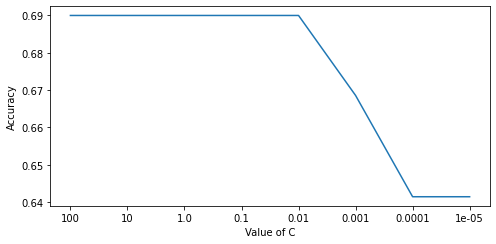

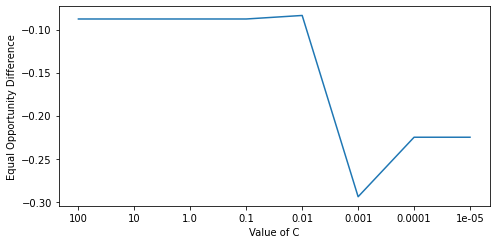

In [29]:
#running crossvalidation for hyperparameter tuning
tuningcv(german_train,german_test)

We can see from the about graphs that:


 

*   The best Value of C for the most accurate result can be any of the values above 0.01 ( we will use 0.01)
*   The best Value of C for the most fair result will be for values over 0.1 (we will use 0.1)



In [30]:
#calculating the metrics of the most accurate and most fiar result
#Geting the metrics of the most accurate result
print("The metrics of the most accurate result:")
runmodel(german_train,german_test,0.01) #most accurate result at C = 0.01
#Geting the metrics of the most fair result
print("The metrics of the most fair result:")
runmodel(german_train,german_test,0.01) #most accurate result at C = 0.00001

The metrics of the most accurate result:
{'acc': 0.6966666666666667, 'eq_opp_diff': -0.15666666666666673, 'avg_odds_diff': -0.2752564102564103, 'disp_imp': 0.7661199095022625}
The metrics of the most fair result:
{'acc': 0.6966666666666667, 'eq_opp_diff': -0.15666666666666673, 'avg_odds_diff': -0.2752564102564103, 'disp_imp': 0.7661199095022625}


As both the C are same we have the same model as both most accurate and most fair

##  Task 2


for value of c: 100
Fold:  1
{'acc': 0.7357142857142858, 'eq_opp_diff': 0.049455535390199645, 'avg_odds_diff': -0.041938898971566885, 'disp_imp': 0.9726177437020811}
Fold:  2
{'acc': 0.6285714285714286, 'eq_opp_diff': -0.03732394366197189, 'avg_odds_diff': -0.11063521597814319, 'disp_imp': 0.8815824645816626}
Fold:  3
{'acc': 0.7785714285714286, 'eq_opp_diff': -0.014285714285714346, 'avg_odds_diff': 0.10396825396825393, 'disp_imp': 1.0527131782945736}
Fold:  4
{'acc': 0.6428571428571429, 'eq_opp_diff': 0.06711065573770492, 'avg_odds_diff': 0.07431619743406986, 'disp_imp': 1.0777511961722488}
Fold:  5
{'acc': 0.6785714285714286, 'eq_opp_diff': -0.10366197183098591, 'avg_odds_diff': -0.13344018131779184, 'disp_imp': 0.8602150537634409}

for value of c: 10
Fold:  1
{'acc': 0.7357142857142858, 'eq_opp_diff': 0.049455535390199645, 'avg_odds_diff': -0.041938898971566885, 'disp_imp': 0.9726177437020811}
Fold:  2
{'acc': 0.6285714285714286, 'eq_opp_diff': -0.03732394366197189, 'avg_odds_diff'

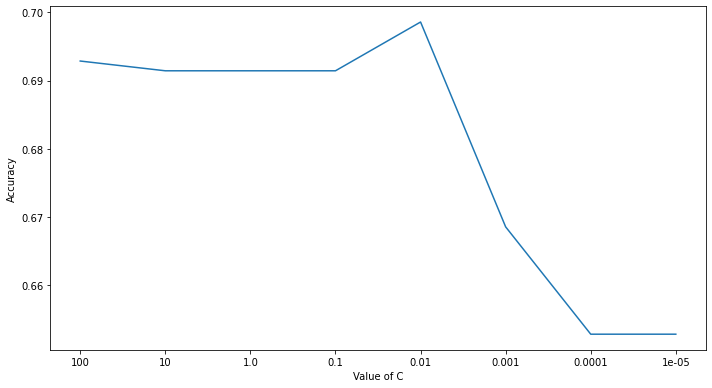

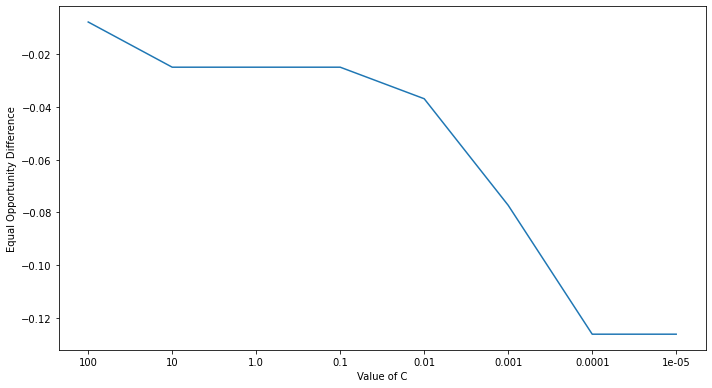

In [37]:
#running crossvalidation  for hyperparameter tuning with reweighing
tuningcvrw(german_train,german_test)

We can see from the about graphs that:


 

*   The best Value of C for the most accurate result with c = 0.01
*   The best Value of C for the most fair result with c = 100 as that is the closest to 0.

In this case c = 0.01 is the best hyperpapameter



In [32]:
#calculating the metrics of the most accurate and most fiar result
#Geting the metrics of the most accurate result
print("The metrics of the most accurate result:")
runmodelrw(german_train,german_test,0.01) #most accurate result at C = 0.01
#Geting the metrics of the most fair result
print("The metrics of the most fair result:")
runmodelrw(german_train,german_test,100) #most accurate result at C = 0.00001

The metrics of the most accurate result:
{'acc': 0.7066666666666667, 'eq_opp_diff': -0.023333333333333428, 'avg_odds_diff': -0.10858974358974366, 'disp_imp': 0.9242081447963801}
The metrics of the most fair result:
{'acc': 0.7033333333333334, 'eq_opp_diff': -0.01666666666666672, 'avg_odds_diff': -0.1052564102564103, 'disp_imp': 0.9286729184427395}


We can see that there is a slight difference in the accuracy while the fairness metrics improve noticeably.

## Extra (Best models according to GridSearchCV for TASK 1 and 2 with Random Forest)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


()

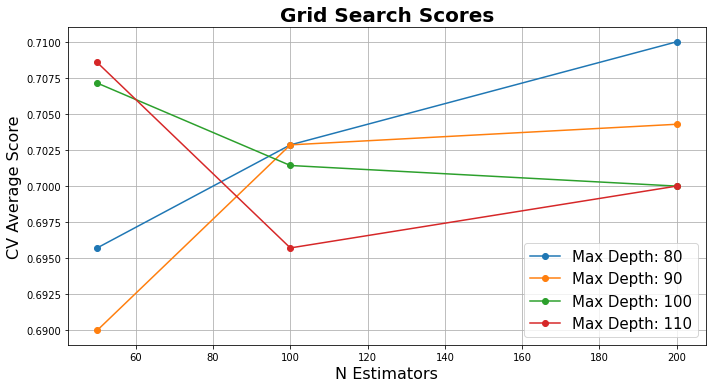

In [33]:
rf(german_train,german_test)

In [34]:
#running the best RandomForestClassifier Model according to the GridSearchCV result
runmodelrf(german_train,german_test,100,90)

{'acc': 0.69, 'eq_opp_diff': -0.026666666666666616, 'avg_odds_diff': -0.0979487179487179, 'disp_imp': 0.9286729184427395}



Fitting 5 folds for each of 12 candidates, totalling 60 fits


()

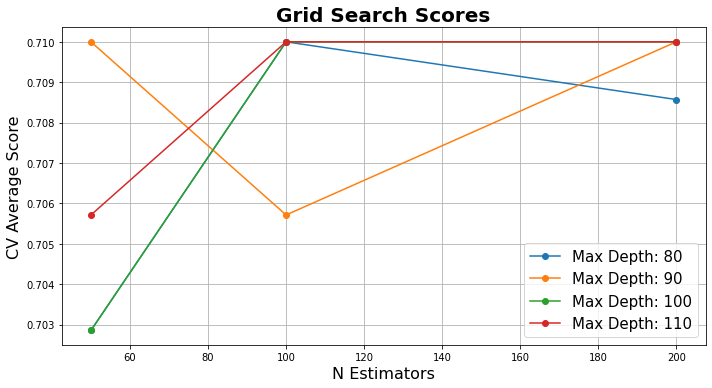

In [35]:
rfrw(german_train,german_test)

In [36]:
#running the best RandomForestClassifier Model according to the GridSearchCV result with reweighing
runmodelrfrw(german_train,german_test,100,110)

{'acc': 0.6866666666666666, 'eq_opp_diff': -0.043333333333333335, 'avg_odds_diff': -0.10628205128205126, 'disp_imp': 0.9164535379369139}


We can see that RandomForestClassifier after reweighing gives a far more fair model than Logistic Regression